# Zero Shot Learning (ZSL) 

In Zero Shot Learning (ZSL), there are labels in the test set that aren't in the training set.

This code uses a modified version of Shrisha Bharadwaj's work at 
https://github.com/sbharadwajj/embarrassingly-simple-zero-shot-learning

The Base paper is:
An embarrassingly simple approach to zero-shot learning http://proceedings.mlr.press/v37/romera-paredes15.pdf

## Part 1: Get the dataset

We will be using a dataset of images of birds. There are 788 images from 200 different types of birds each with 312 attributes. The dataset is called the CUB dataset, which stands for "Caltech UCSB Birds".

You can obtain this and other similar datasets (such as AWA1 or SUN) [here](https://www.mpi-inf.mpg.de/departments/computer-vision-and-machine-learning/research/zero-shot-learning/zero-shot-learning-the-good-the-bad-and-the-ugly/).

### Part 1a: Using Google Colab

Go to Part 1b if you are working in Jupyter notebook.

1. Upload the `CUB` folder to Google Drive.

2. Run the following cells code.

In [1]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

3. Before running the code below, replace the ID with ID of file you want to access.

    To get this ID: 

    1.   Right-click on the name of the appropriate file in your Google Drive
    2.   Click "Get link"
    3.   Copy the characters between `d/` and the following slash
    4.   Paste them into the dictionary argument of the call to `drive.CreateFile()` as the value associated with the 'id' key. Make sure that this value is a string.



In [2]:
res101_id = '1BPPCIWJ2t71L7QjBNC6brKmJR7rohZ1r'
cub_res101 = drive.CreateFile({'id': res101_id}) 
cub_res101.GetContentFile('res101.mat') 
att_splits_id = '1BOOdv59bVtMQYpHwvHeg7tyXhpx045CX'
cub_att_splits = drive.CreateFile({'id': att_splits_id}) 
cub_att_splits.GetContentFile('att_splits.mat')

### Part 1b: Using Jupyter Notebook

1. Download the CUB folder and put it in the same location as the notebook file.

## Part 2: Load & Investigate the Data

The data is stored in `.mat` files, which is a MATLAB binary. We'll be using `scipy` to load in the data.

There are two files:

- `res101` contains the data with features and the corresponding labels.
- `att_splits` contains the indices of the train, validation and test sets as well as attributes for each of the labels.

1. Use the `scipy.io.loadmat()` function to load in the `.mat` files into dictionaries and save them as `res101` and `att_splits`.

In [3]:
import scipy.io as sio

res101 = sio.loadmat('res101.mat')
att_splits = sio.loadmat('att_splits.mat')

2. Examine the `res101` and `att_splits` dictionaries and understand their fields by calling the `.keys()` method on both objects.

In [4]:
print('res101 keys: ', res101.keys())
print('att_splits keys: ', att_splits.keys())

res101 keys:  dict_keys(['__header__', '__version__', '__globals__', 'image_files', 'features', 'labels'])
att_splits keys:  dict_keys(['__header__', '__version__', '__globals__', 'allclasses_names', 'att', 'original_att', 'test_seen_loc', 'test_unseen_loc', 'train_loc', 'trainval_loc', 'val_loc'])


3. How many features and how many datapoints does the dataset have?

    The data is contained in `res101['features']`.

    Note: this dataset has a row for each feature and a column for each datapoint.

In [5]:
features = res101['features']
print('Features shape: ', features.shape)

Features shape:  (2048, 11788)


We have an **attribute** matrix (or **signature** matrix) that has attribute values for each class. Each row corresponds to an attribute and each column a class (or label).

For example, say the classes are `Horse` and `Zebra` and the attributes are [`wild_animal`, `4_legged`, `herbivore`]. This is what the signature matrix might look like.

```
 Horse      Zebra
[0.00354613 0.        ] wild_animal
[0.13829921 0.20209503] 4_legged
[0.06560347 0.04155225] herbivore
```

4. How many classes and how many attributes are there?

    The attribute matrix can be found in `att_splits['att']`.

In [6]:
attr = att_splits['att']
print('Attribute matrix shape: ', attr.shape)

Attribute matrix shape:  (312, 200)


5. Verify that the data contains 200 unique labels. The labels are found in `res101['labels']`.

In [7]:
import numpy as np

labels = res101['labels']
np.unique(labels)

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

## Part 3: Prepare the training & test sets

In `att_splits` there are five subsets of the data: train, val, trainval, test_seen and test_unseen.

Note that trainval is the combination of the train and val sets. We will start by using the trainval set as our training set.

In a typical zero-shot learning scenario, there are no overlapping classes between training and testing phase, i.e the train classes are completely different from the test classes.

The test_seen set is a test set with labels already seen, so we will use the test_unseen set as our test set.

1. Get list of labels for the `trainval` and `test_unseen` subsets.

    The code below does the computation for trainval, so do the same for test.

    Note: `att_splits['trainval_loc']` gives the locations of the data for that subset. The values will range from 1 to 11788, so we need to subtract 1 to get the indices.

In [8]:
labels = res101['labels'].squeeze() - 1
trainval_ind = att_splits['trainval_loc'].squeeze() - 1
labels_trainval = labels[trainval_ind]

test_ind = att_splits['test_unseen_loc'].squeeze() - 1
labels_test = labels[test_ind]

In [9]:
labels_trainval.shape

(7057,)

2. How many unique labels are there in each training set?

    Create the numpy arrays `unique_trainval_labels` and `unique_test_labels` since we will be using them later.

In [10]:
unique_trainval_labels = np.unique(labels_trainval)
unique_test_labels = np.unique(labels_test)

print('Unique train labels: ', len(unique_trainval_labels))
print('Unique test labels: ', len(unique_test_labels))

Unique train labels:  150
Unique test labels:  50


3. Verify that there is no overlap between the labels in `trainval` and in `test`.

In [11]:
intersection = len(set(unique_trainval_labels).intersection(set(unique_test_labels)))
print('Number of overlapping labels', intersection)

Number of overlapping labels 0


4. Get the feature matrices for the trainval and test sets and save them as `trainval_features` and `test_features`.

    Recall that the feature matrix is `res101['features']`. We need to subset the rows using `trainval_ind` and `test_ind`.

In [12]:
X = res101['features']

trainval_features = X[:, np.squeeze(att_splits['trainval_loc']-1)]
test_features = X[:, np.squeeze(att_splits['test_unseen_loc']-1)]

5. How many datapoints and features do `trainval_features` and `test_features` have?

    Note: They should both have the same number of features as the full feature matrix.

In [13]:
print('Train features shape: ', trainval_features.shape)
print('Test features shape: ', test_features.shape)

Train features shape:  (2048, 7057)
Test features shape:  (2048, 2967)


## Part 4: Prepare for the Zero Shot Learning model

For our model, we need the class labels to map to array indices and not have gaps between labels. For the trainval set, we have 150 labels, but the label numbers are between 1 and 200, so there are skipped numbers. Let's reindex the labels so the numbers range for 0 to 149 for the trainval set.

The test set has 50 labels, so we'll reindex the numbers to range from 0 to 49.

1. The example below creates new labels for the trainval set (`labels_index_trainval`). Follow the same pattern to create new labels for the test set (`labels_index_test`).

In [14]:
labels_index_trainval = np.zeros(labels_trainval.shape[0]).astype(int)
for i, label in enumerate(unique_trainval_labels):
    labels_index_trainval[labels_trainval == label] = i

labels_index_test = np.zeros(labels_test.shape[0]).astype(int)
for j, target in enumerate(unique_test_labels):
    labels_index_test[labels_test == target] = j

2. Verify that `labels_index_trainval` has 150 unique values ranging from 0 to 149 and that `labels_index_test` has 50 unique values ranging from 0 to 49.

In [15]:
print('Min and max train labels: ', (labels_index_trainval).min(), (labels_index_trainval).max())
print('Min and max test labels: ', (labels_index_test).min(), (labels_index_test).max())

Min and max train labels:  0 149
Min and max test labels:  0 49


To make our model work with unseen labels, we will be using what's known as the **attribute** or **signature** matrix. This matrix has values for 312 attributes of each of the 200 labels.

3. Create signature matrices for the training and test sets. Follow the example shown for `trainval_sig` to create `test_sig`.

In [16]:
signature = att_splits['att']
trainval_sig = signature[:, unique_trainval_labels]
test_sig = signature[:, unique_test_labels]

4. Verify the shapes of the two matrices. They should have a row for each attribute and a column for each label.

In [17]:
print('Shape of train matrix: ', trainval_sig.shape)
print('Shape of test matrix: ', test_sig.shape)

Shape of train matrix:  (312, 150)
Shape of test matrix:  (312, 50)


For our training set, we create **ground truth matrices** with dimensions `[number of datapoints] x [number of unique classes]`. Each value is 1 if the datapoint belongs to the class and 0 otherwise. So each row will have exactly one 1.

5. Create the ground truth matrix for the trainval set. We initialize it to all zeros. Fill in 1's where they belong.

In [18]:
import numpy as np

gt_trainval = np.zeros((labels_trainval.shape[0], unique_trainval_labels.shape[0])).astype(int)
gt_trainval[np.arange(labels_trainval.shape[0]), np.squeeze(labels_index_trainval)] = 1
gt_trainval[:1,:150]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]])

## Part 5: Build the Zero Shot Learning model

We will be using the following formula for the zero shot learning model. First we calculate $V$ as follows.
$$V = (X \cdot X^T + \alpha I_{\texttt{n_features}})^{-1} \cdot X \cdot Y \cdot S^T \cdot (S \cdot S^T + \gamma I_{\texttt{n_attributes}})^{-1}$$

Here are the terms defined:

* $X$: feature matrix (e.g. `trainval_features`)
* $Y$: ground truth matrix (e.g. `gt_trainval`)
* $S$: signature matrix (e.g. `trainval_sig`)
* $alpha$: regularization parameter for $X$, since $X$ is wider than it is tall
* $gamma$: regularization parameter for $S$, since $S$ is wider than it is tall

After calculating $V$ from the training set, we are able to make predictions with a new test set using the following:

$$\hat{y} = \textrm{argmax}(X_{\texttt{test}}^T \cdot V \cdot S_{\texttt{test}})$$

For details on the derivation, please see the paper http://proceedings.mlr.press/v37/romera-paredes15.pdf

Let's go through step by step how to build this model.

1. Write the function `calculate_V` to calculate $V$ as defined above.

    Notes:
    - Use pseudoinverses rather than standard matrix inverses.
    - Use $10^\alpha$ as $\alpha$ and $10^y$ as $y$. 

In [19]:
def calculate_V(X, Y, S, alpha=0, gamma=0):
    term1 = np.linalg.pinv(np.dot(trainval_features, trainval_features.T) + (10**alpha) * np.eye(trainval_features.shape[0]))
    term2 = np.dot(np.dot(trainval_features, gt_trainval), trainval_sig.T)
    term3 = np.linalg.pinv(np.dot(trainval_sig, trainval_sig.T) + (10**gamma) * np.eye(trainval_sig.shape[0]))
    return np.dot(np.dot(term1, term2), term3)

2. Verify that $V$ created using your `calculate_V()` function has the correct shape. It should have 2048 (number of features) rows and 312 (number of attributes) columns.

In [20]:
V = calculate_V(trainval_features, gt_trainval, trainval_sig)

V.shape

(2048, 312)

3. Write the function `calculate_predictions()` which finds the predictions according to

    $$\hat{y} = \textrm{argmax}(X_{\texttt{test}}^T \cdot V \cdot S_{\texttt{test}})$$

In [29]:
def calculate_predictions(V, X, S):
  yhat = np.dot(np.dot(X.T, V), S)
  return np.array([np.argmax(y) for y in yhat])

4. Look at the first 10 predictions and compare them to the first ten values in `labels_index_test`.

In [30]:
pred = calculate_predictions(V, test_features, test_sig)

print('First 10 predictions: ', pred[:10])
print('First 10 actual values: ', labels_index_test[:10])

First 10 predictions:  [10 30 28  0  8 33  9 20 28 28]
First 10 actual values:  [32 32 32 32 32 32 32 32 32 32]


5. Calculate the confusion matrix comparing the actual labels (`labels_index_test`) with the predictions (`pred`). Save it in the `cm` variable.

In [31]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(labels_index_test, pred)

6. Use the result and the `one_percent_accuracy()` function (defined below) to get the 1% accuracy for the zero shot learning model.

In [32]:
def one_percent_accuracy(cm):
    cm = cm / cm.sum(axis=1)[:, np.newaxis]
    cm = np.nan_to_num(cm, nan=0)
    return np.mean(cm.diagonal())

print('1% Accuracy: ', one_percent_accuracy(cm)*100)

1% Accuracy:  22.078927005271634


7. Use the `cm_heatmap()` function (defined below) to get a heatmap of the confusion matrix. What do you observe looking at it?

None


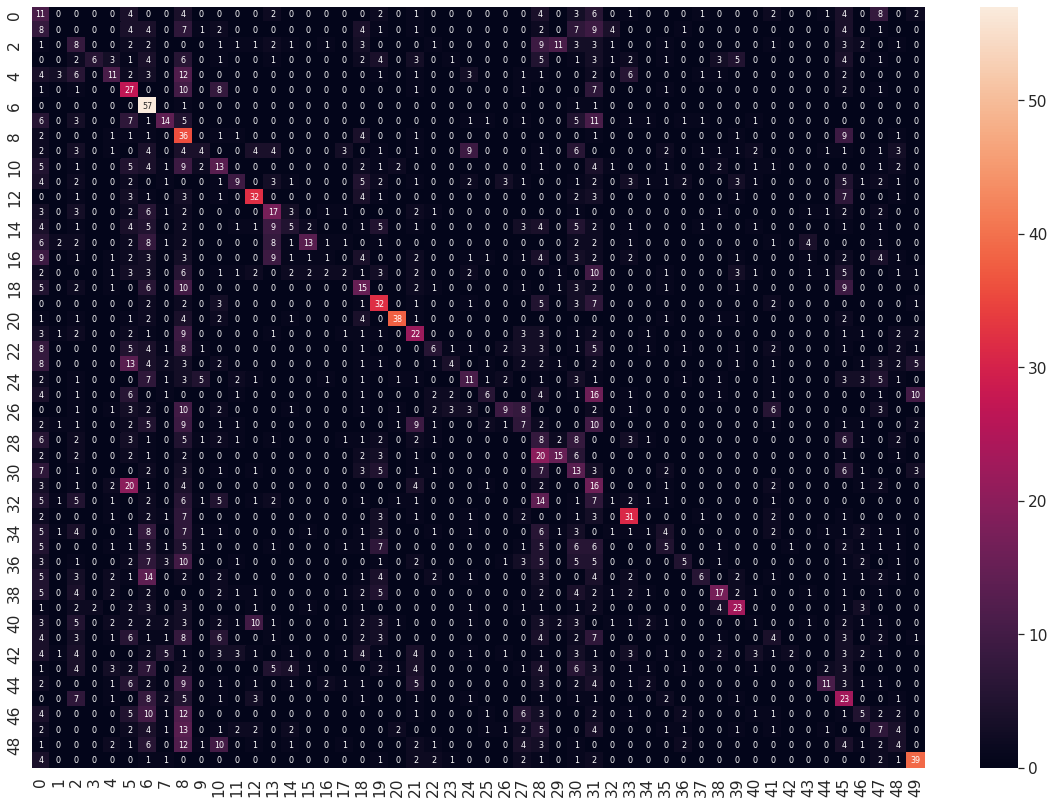

In [33]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

def cm_heatmap(cm):
    df_cm = pd.DataFrame(cm, range(cm.shape[0]), range(cm.shape[1]))
    sn.set(font_scale=1.4) # for label size
    plt.figure(figsize=(20, 14))
    sn.heatmap(df_cm,annot=True, annot_kws={"size": 8}) # font size

print(cm_heatmap(cm))

## Part 6: Hyper-Parameter Tuning

For hyper-parameter tuning, we will be training on the train set and validating on the test set. So first we need to setup and train and val sets (like we did with the trainval and test sets previously).

1. Run the following code to setup the arrays we need for the train and val sets.

In [34]:
train_ind = att_splits['train_loc'].squeeze() - 1
labels_train = labels[train_ind]

val_ind = att_splits['val_loc'].squeeze() - 1
labels_val = labels[val_ind]

unique_train_labels = np.unique(labels_train)
unique_val_labels = np.unique(labels_val)

train_features = res101['features'][:, train_ind]
val_features = res101['features'][:, val_ind]

labels_index_train = np.zeros(labels_train.shape[0]).astype(int)
for i, label in enumerate(unique_train_labels):
    labels_index_train[labels_train == label] = i

labels_index_val = np.zeros(labels_val.shape[0]).astype(int)
for i, label in enumerate(unique_val_labels):
    labels_index_val[labels_val == label] = i

train_sig = signature[:, unique_train_labels]
val_sig = signature[:, unique_val_labels]

gt_train = np.zeros((labels_train.shape[0], unique_train_labels.shape[0])).astype(int)
gt_train[np.arange(labels_train.shape[0]), labels_index_train] = 1

2. Run the following snippet to obtain the best `alph1` and `gamm1`.

In [35]:
accu = 0
alph1 = None
gamm1 = None
for alpha in range(-3, 4):
    for gamma in range(-3, 4):
        V = calculate_V(train_features, gt_train, train_sig, alpha, gamma)
        pred = calculate_predictions(V, val_features, val_sig)
        cm = confusion_matrix(labels_index_val, pred)
        cm = cm / cm.sum(axis=1)[:, np.newaxis]
        avg = sum(cm.diagonal()) / unique_val_labels.shape[0]
        print(f'Avg={avg:.4f}, alpha={alpha}, gamma={gamma}')

        if avg > accu:
            accu = avg
            alph1 = alpha
            gamm1 = gamma
print('Optimal Alpha:', alph1)
print('Optimal Gamma:', gamm1)
print('Accuracy:', accu)

Avg=0.9963, alpha=-3, gamma=-3
Avg=0.9946, alpha=-3, gamma=-2
Avg=0.9878, alpha=-3, gamma=-1
Avg=0.9556, alpha=-3, gamma=0
Avg=0.9162, alpha=-3, gamma=1
Avg=0.9471, alpha=-3, gamma=2
Avg=0.9457, alpha=-3, gamma=3
Avg=0.9963, alpha=-2, gamma=-3
Avg=0.9946, alpha=-2, gamma=-2
Avg=0.9878, alpha=-2, gamma=-1
Avg=0.9556, alpha=-2, gamma=0
Avg=0.9162, alpha=-2, gamma=1
Avg=0.9471, alpha=-2, gamma=2
Avg=0.9457, alpha=-2, gamma=3
Avg=0.9963, alpha=-1, gamma=-3
Avg=0.9946, alpha=-1, gamma=-2
Avg=0.9878, alpha=-1, gamma=-1
Avg=0.9552, alpha=-1, gamma=0
Avg=0.9162, alpha=-1, gamma=1
Avg=0.9471, alpha=-1, gamma=2
Avg=0.9457, alpha=-1, gamma=3
Avg=0.9963, alpha=0, gamma=-3
Avg=0.9946, alpha=0, gamma=-2
Avg=0.9874, alpha=0, gamma=-1
Avg=0.9552, alpha=0, gamma=0
Avg=0.9162, alpha=0, gamma=1
Avg=0.9467, alpha=0, gamma=2
Avg=0.9440, alpha=0, gamma=3
Avg=0.9958, alpha=1, gamma=-3
Avg=0.9942, alpha=1, gamma=-2
Avg=0.9852, alpha=1, gamma=-1
Avg=0.9547, alpha=1, gamma=0
Avg=0.9098, alpha=1, gamma=1
Avg=0.9

3. Use the optimal values of `alph1` and `gamm1` to re-build the Zero Shot Learning model and report the 1% accuracy.

In [36]:
def calculate_V(X, Y, S, alpha=0, gamma=0):
    term1 = np.linalg.pinv(np.dot(train_features, train_features.T) + (10**alpha) * np.eye(train_features.shape[0]))
    term2 = np.dot(np.dot(train_features, gt_train), train_sig.T)
    term3 = np.linalg.pinv(np.dot(train_sig, train_sig.T) + (10**gamma) * np.eye(train_sig.shape[0]))
    return np.dot(np.dot(term1, term2), term3)

In [37]:
V = calculate_V(train_features, gt_train, train_sig)

In [38]:
def calculate_predictions(V, X, S):
  yhat = np.dot(np.dot(val_features.T, V), val_sig)
  return np.array([np.argmax(y) for y in yhat])

In [39]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(labels_index_val, pred)

In [40]:
def one_percent_accuracy(cm):
    cm = cm / cm.sum(axis=1)[:, np.newaxis]
    cm = np.nan_to_num(cm, nan=0)
    return np.mean(cm.diagonal())

print('1% Accuracy using optimal values of alph1 and gamm1: ', one_percent_accuracy(cm)*100)

1% Accuracy using optimal values of alph1 and gamm1:  79.06859992824538
